##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF Lattice Canned Estimator

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/lattice/tutorials/canned_estimators"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看 </a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/canned_estimators.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">Run in Google Colab</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/lattice/tutorials/canned_estimators.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 中查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/lattice/tutorials/canned_estimators.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
</table>

## 概述

利用 Canned Estimator，您可以快速轻松地针对典型用例训练 TFL 模型。本指南概述了创建 TFL Canned Estimator 所需的步骤。

## 设置

安装 TF Lattice 软件包：

In [2]:
#@test {"skip": true}
!pip install tensorflow-lattice

导入所需的软件包：

In [3]:
import tensorflow as tf

import copy
import logging
import numpy as np
import pandas as pd
import sys
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
logging.disable(sys.maxsize)

下载 UCI Statlog (Heart) 数据集：

In [4]:
csv_file = tf.keras.utils.get_file(
    'heart.csv', 'http://storage.googleapis.com/download.tensorflow.org/data/heart.csv')
df = pd.read_csv(csv_file)
target = df.pop('target')
train_size = int(len(df) * 0.8)
train_x = df[:train_size]
train_y = target[:train_size]
test_x = df[train_size:]
test_y = target[train_size:]
df.head()

16384/13273 [=====================================] - 0s 0us/step


24576/13273 [=======================================================] - 0s 0us/step


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  
0   0       fixed  
1   3      normal  
2   2  reversible  
3   0      normal  
4   0      normal

设置用于在本指南中进行训练的默认值：

In [5]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 500
PREFITTING_NUM_EPOCHS = 10

## 特征列

与任何其他 TF Estimator 一样，数据通常需要通过 input_fn 传递给 Estimator，并使用 [FeatureColumns](https://tensorflow.google.cn/guide/feature_columns) 进行解析。

In [6]:
# Feature columns.
# - age
# - sex
# - cp        chest pain type (4 values)
# - trestbps  resting blood pressure
# - chol      serum cholestoral in mg/dl
# - fbs       fasting blood sugar > 120 mg/dl
# - restecg   resting electrocardiographic results (values 0,1,2)
# - thalach   maximum heart rate achieved
# - exang     exercise induced angina
# - oldpeak   ST depression induced by exercise relative to rest
# - slope     the slope of the peak exercise ST segment
# - ca        number of major vessels (0-3) colored by flourosopy
# - thal      3 = normal; 6 = fixed defect; 7 = reversable defect
feature_columns = [
    fc.numeric_column('age', default_value=-1),
    fc.categorical_column_with_vocabulary_list('sex', [0, 1]),
    fc.numeric_column('cp'),
    fc.numeric_column('trestbps', default_value=-1),
    fc.numeric_column('chol'),
    fc.categorical_column_with_vocabulary_list('fbs', [0, 1]),
    fc.categorical_column_with_vocabulary_list('restecg', [0, 1, 2]),
    fc.numeric_column('thalach'),
    fc.categorical_column_with_vocabulary_list('exang', [0, 1]),
    fc.numeric_column('oldpeak'),
    fc.categorical_column_with_vocabulary_list('slope', [0, 1, 2]),
    fc.numeric_column('ca'),
    fc.categorical_column_with_vocabulary_list(
        'thal', ['normal', 'fixed', 'reversible']),
]

TFL Canned Estimator 使用特征列的类型来决定要使用哪种类型的校准层。对于数字特征列，我们使用 `tfl.layers.PWLCalibration` 层；对于分类特征列，我们使用 `tfl.layers.CategoricalCalibration` 层。

请注意，分类特征列不是由嵌入特征列包装。它们直接馈送到 Estimator 中。

## 创建 input_fn

与其他任何 Estimator 一样，您可以使用 input_fn 将数据馈送给模型进行训练和评估。TFL Estimator 可以自动计算特征的分位数，并将其用作 PWL 校准层的输入关键点。为此，它们需要传递 `feature_analysis_input_fn`，此函数与训练 input_fn 类似，但使用单个周期或数据的子样本。

In [7]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    num_threads=1)

# feature_analysis_input_fn is used to collect statistics about the input.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    # Note that we only need one pass over the data.
    num_epochs=1,
    num_threads=1)

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=test_x,
    y=test_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

# Serving input fn is used to create saved models.
serving_input_fn = (
    tf.estimator.export.build_parsing_serving_input_receiver_fn(
        feature_spec=fc.make_parse_example_spec(feature_columns)))

## 特征配置

使用 <code>tfl.configs.FeatureConfig</code> 设置特征校准和按特征的配置。特征配置包括单调性约束、按特征的正则化（请参阅 <code>tfl.configs.RegularizerConfig</code>）以及点阵模型的点阵大小。

如果没有为输入特征定义配置，则使用 `tfl.config.FeatureConfig` 中的默认配置。

In [8]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='age',
        lattice_size=3,
        # By default, input keypoints of pwl are quantiles of the feature.
        pwl_calibration_num_keypoints=5,
        monotonicity='increasing',
        pwl_calibration_clip_max=100,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='cp',
        pwl_calibration_num_keypoints=4,
        # Keypoints can be uniformly spaced.
        pwl_calibration_input_keypoints='uniform',
        monotonicity='increasing',
    ),
    tfl.configs.FeatureConfig(
        name='chol',
        # Explicit input keypoint initialization.
        pwl_calibration_input_keypoints=[126.0, 210.0, 247.0, 286.0, 564.0],
        monotonicity='increasing',
        # Calibration can be forced to span the full output range by clamping.
        pwl_calibration_clamp_min=True,
        pwl_calibration_clamp_max=True,
        # Per feature regularization.
        regularizer_configs=[
            tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
        ],
    ),
    tfl.configs.FeatureConfig(
        name='fbs',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
    ),
    tfl.configs.FeatureConfig(
        name='trestbps',
        pwl_calibration_num_keypoints=5,
        monotonicity='decreasing',
    ),
    tfl.configs.FeatureConfig(
        name='thalach',
        pwl_calibration_num_keypoints=5,
        monotonicity='decreasing',
    ),
    tfl.configs.FeatureConfig(
        name='restecg',
        # Partial monotonicity: output(0) <= output(1), output(0) <= output(2)
        monotonicity=[(0, 1), (0, 2)],
    ),
    tfl.configs.FeatureConfig(
        name='exang',
        # Partial monotonicity: output(0) <= output(1)
        monotonicity=[(0, 1)],
    ),
    tfl.configs.FeatureConfig(
        name='oldpeak',
        pwl_calibration_num_keypoints=5,
        monotonicity='increasing',
    ),
    tfl.configs.FeatureConfig(
        name='slope',
        # Partial monotonicity: output(0) <= output(1), output(1) <= output(2)
        monotonicity=[(0, 1), (1, 2)],
    ),
    tfl.configs.FeatureConfig(
        name='ca',
        pwl_calibration_num_keypoints=4,
        monotonicity='increasing',
    ),
    tfl.configs.FeatureConfig(
        name='thal',
        # Partial monotonicity:
        # output(normal) <= output(fixed)
        # output(normal) <= output(reversible)        
        monotonicity=[('normal', 'fixed'), ('normal', 'reversible')],
    ),
]

## 校准线性模型

要构造 TFL Canned Estimator，请从 `tfl.configs` 构造模型配置。使用 `tfl.configs.CalibratedLinearConfig` 构造校准线性模型。此模型会将分段线性和分类校准应用于输入特征，随后应用线性组合和可选的输出分段线性校准。使用输出校准或指定输出边界时，线性层会将加权平均应用于校准的输入。

下面的示例将基于前 5 个特征创建一个校准线性模型。我们利用 `tfl.visualization` 绘制带校准器图的模型计算图。

Calibrated linear test AUC: 0.834586501121521


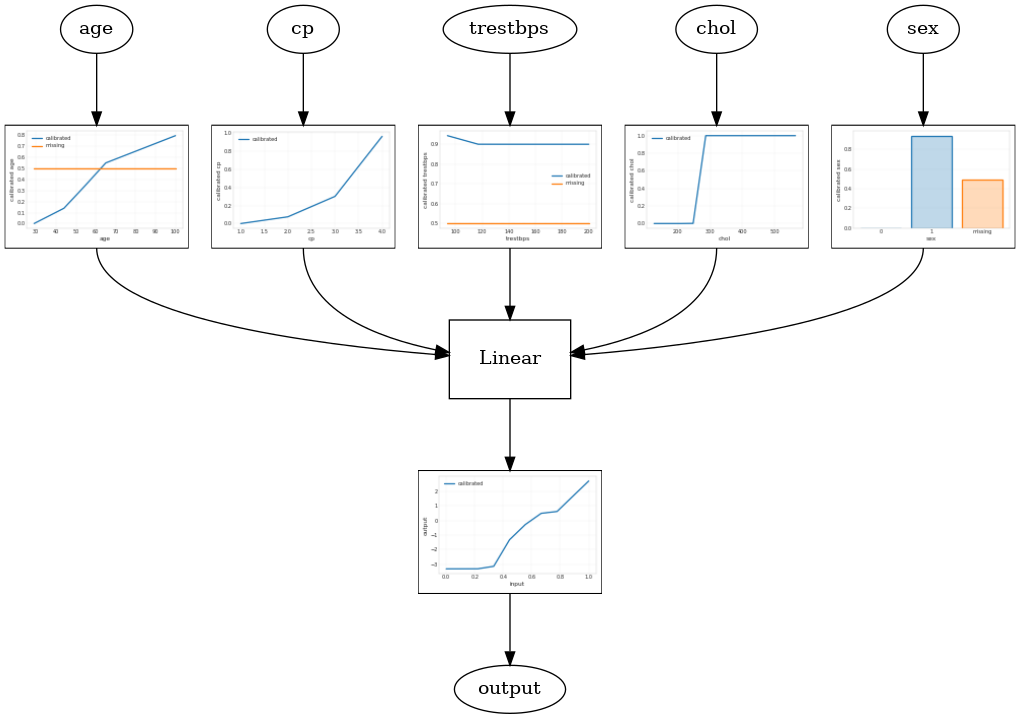

In [9]:
# Model config defines the model structure for the estimator.
model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    use_bias=True,
    output_calibration=True,
    regularizer_configs=[
        # Regularizer for the output calibrator.
        tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns[:5],
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Calibrated linear test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph)

## 校准点阵模型

使用 `tfl.configs.CalibratedLatticeConfig` 构造校准点阵模型。校准点阵模型会将分段线性和分类校准应用于输入特征，随后应用点阵模型和可选的输出分段线性校准。

下面的示例将基于前 5 个特征创建一个校准点阵模型。


Calibrated lattice test AUC: 0.8427318334579468


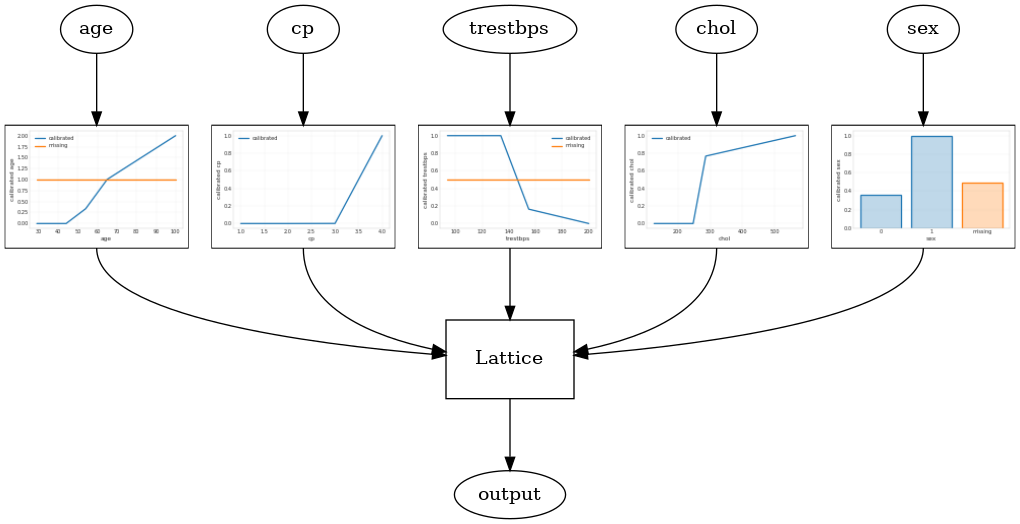

In [10]:
# This is calibrated lattice model: Inputs are calibrated, then combined
# non-linearly using a lattice layer.
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs,
    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-4),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
    ])
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns[:5],
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Calibrated lattice test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph)

## 校准点阵集成

当特征数量很大时，可以使用集成模型，这种模型会为特征的子集创建多个较小的点阵并计算它们的输出平均值，而不是仅创建单个巨大的点阵。使用 `tfl.configs.CalibratedLatticeEnsembleConfig` 构造集成点阵模型。校准点阵集成模型会将分段线性和分类校准应用于输入特征，随后应用点阵模型的集成和可选的输出分段线性校准。


### 随机点阵集成

以下模型配置为每个点阵使用特征的随机子集。

Random ensemble test AUC: 0.9003759622573853


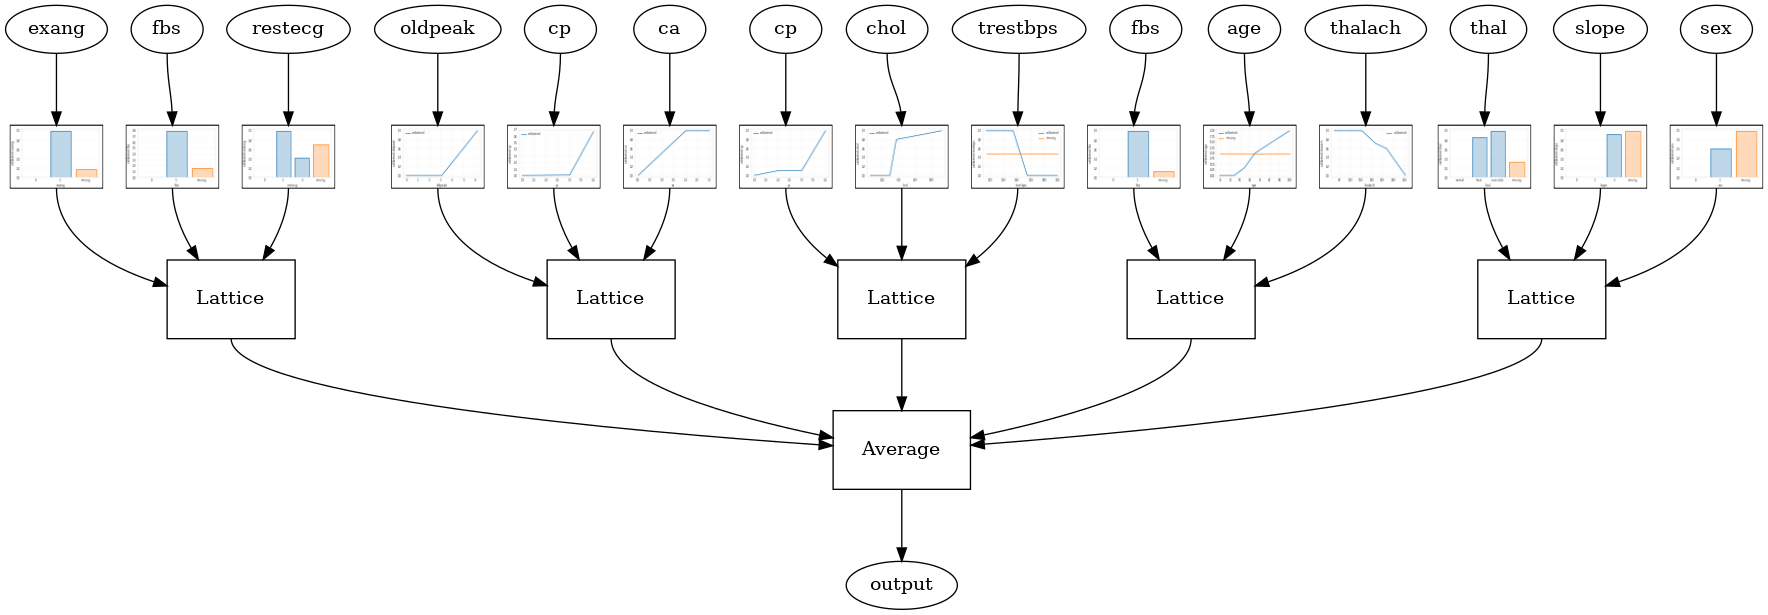

In [11]:
# This is random lattice ensemble model with separate calibration:
# model output is the average output of separately calibrated lattices.
model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    num_lattices=5,
    lattice_rank=3)
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Random ensemble test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph, calibrator_dpi=15)

### RTL 层随机点阵集成

以下模型配置使用 `tfl.layers.RTL` 层，该层为每个点阵使用特征的随机子集。我们注意到，`tfl.layers.RTL` 仅支持单调性约束，对于所有特征都必须具有相同的点阵大小，并且不包含按特征的正则化。请注意，与使用单独的 `tfl.layers.Lattice` 实例相比，使用 `tfl.layers.RTL` 层可使您扩展到更大的集成。

Random ensemble test AUC: 0.8903508186340332


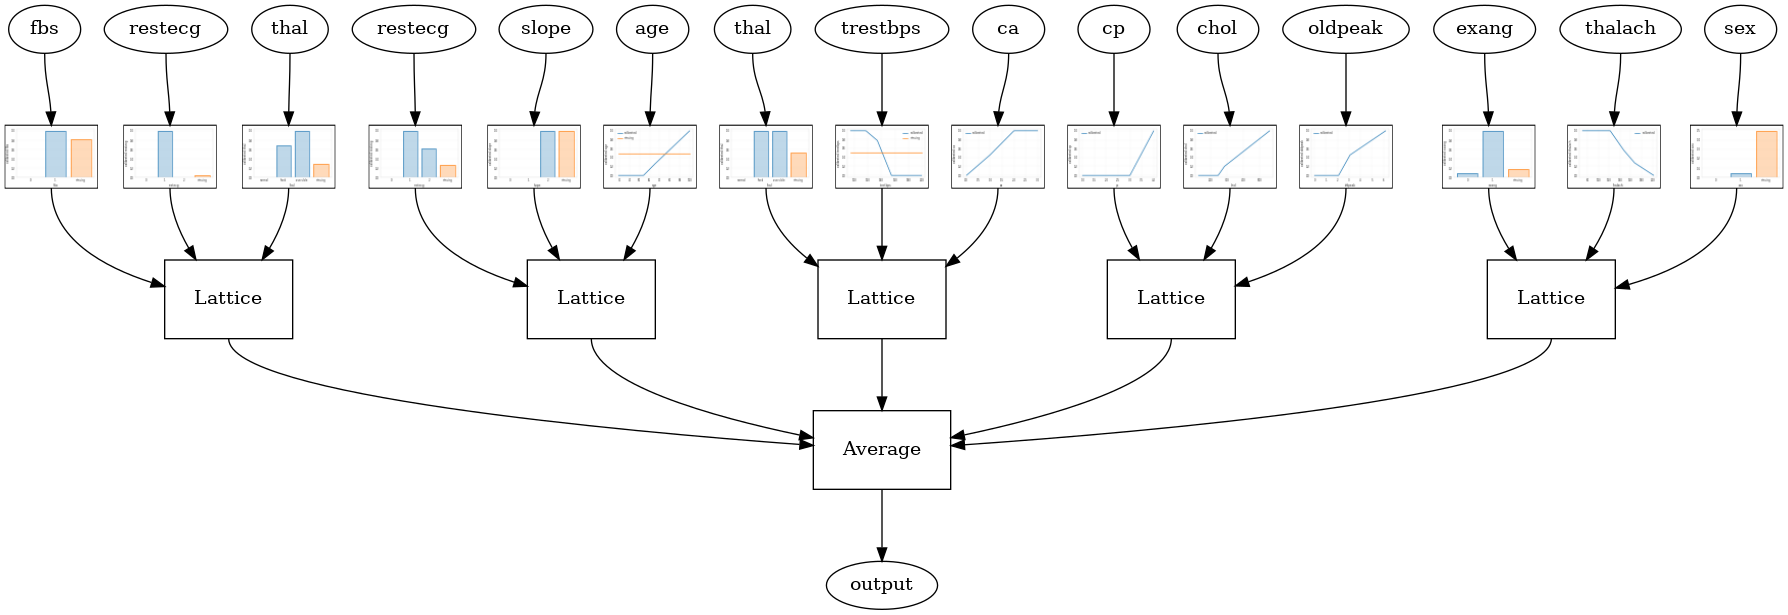

In [12]:
# Make sure our feature configs have the same lattice size, no per-feature
# regularization, and only monotonicity constraints.
rtl_layer_feature_configs = copy.deepcopy(feature_configs)
for feature_config in rtl_layer_feature_configs:
  feature_config.lattice_size = 2
  feature_config.unimodality = 'none'
  feature_config.reflects_trust_in = None
  feature_config.dominates = None
  feature_config.regularizer_configs = None
# This is RTL layer ensemble model with separate calibration:
# model output is the average output of separately calibrated lattices.
model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    lattices='rtl_layer',
    feature_configs=rtl_layer_feature_configs,
    num_lattices=5,
    lattice_rank=3)
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Random ensemble test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph, calibrator_dpi=15)

### 晶体点阵集成

TFL 还提供了一种称为[晶体](https://papers.nips.cc/paper/6377-fast-and-flexible-monotonic-functions-with-ensembles-of-lattices)的启发式特征排列算法。晶体算法将先训练一个*预拟合模型*，此模型会估算成对的特征交互。然后，它将对最终集成进行排列，使具有更多非线性交互的特征处于同一点阵中。

对于晶体模型，您还需要提供用于训练上述预拟合模型的 `prefitting_input_fn`。拟合模型不需要完全训练，因此几个周期便已足够。


In [13]:
prefitting_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_x,
    y=train_y,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=PREFITTING_NUM_EPOCHS,
    num_threads=1)

然后，您可以通过在模型配置中设置 `lattice='crystals'` 来创建晶体模型。

Crystals ensemble test AUC: 0.8853383660316467


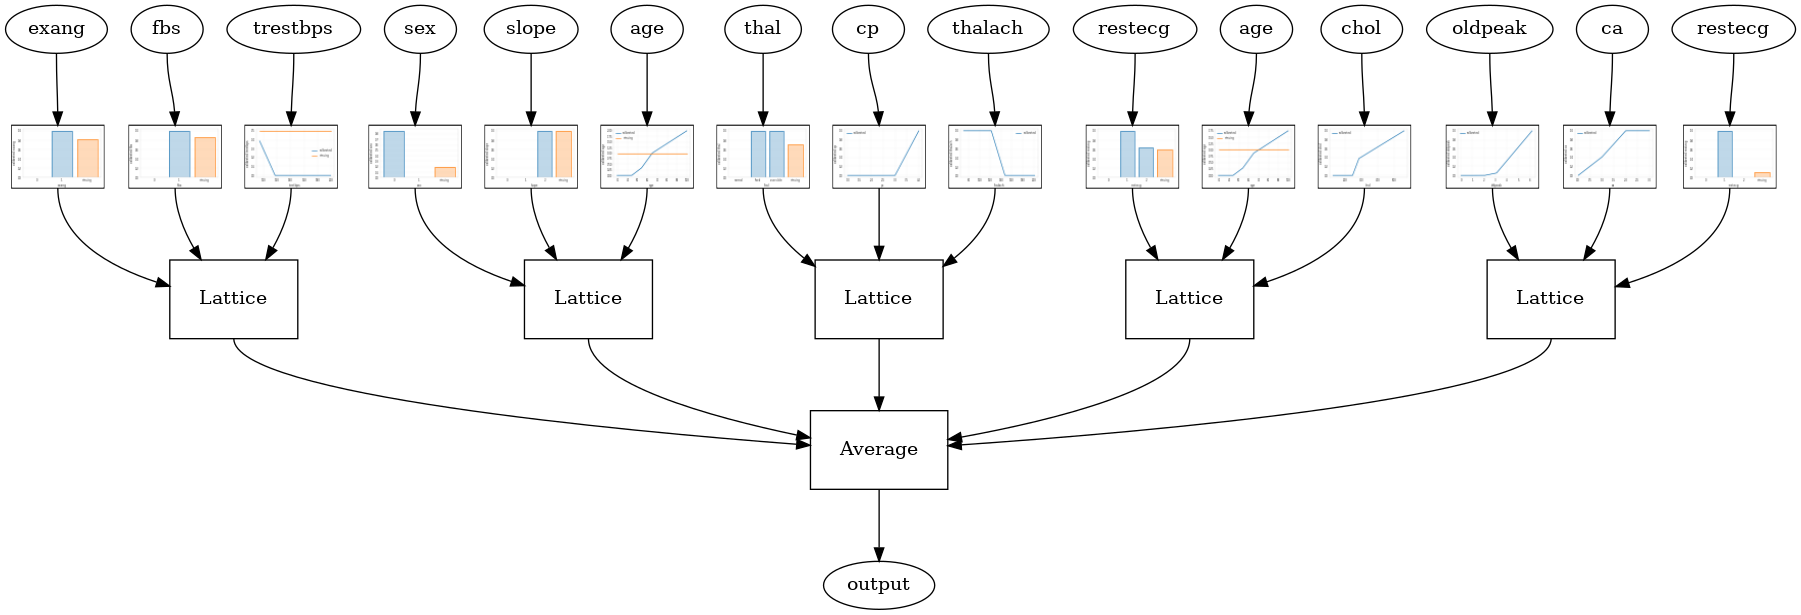

In [14]:
# This is Crystals ensemble model with separate calibration: model output is
# the average output of separately calibrated lattices.
model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices='crystals',
    num_lattices=5,
    lattice_rank=3)
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    # prefitting_input_fn is required to train the prefitting model.
    prefitting_input_fn=prefitting_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    prefitting_optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42))
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Crystals ensemble test AUC: {}'.format(results['auc']))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph, calibrator_dpi=15)

您可以使用 `tfl.visualization` 模块绘制包含更多细节的特征校准器。

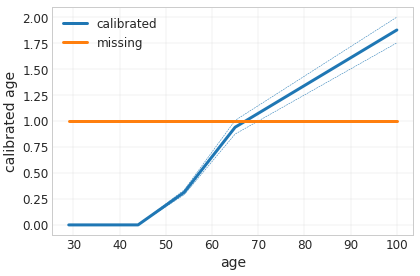

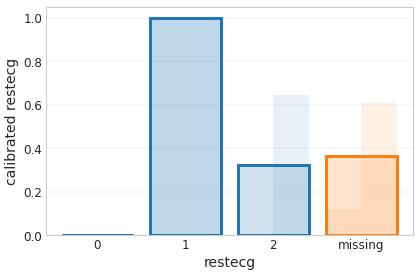

In [15]:
_ = tfl.visualization.plot_feature_calibrator(model_graph, "age")
_ = tfl.visualization.plot_feature_calibrator(model_graph, "restecg")